In [1]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.6 MB/s eta 0:00:00


In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from keras import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import keras.backend as K
from sklearn import model_selection, metrics
from sklearn.metrics import classification_report
import math
from keras import backend as K
import os
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import glob
import time
from tensorflow.keras.callbacks import *
from segmentation_models.metrics import f1_score, f2_score, iou_score, precision, recall
from segmentation_models.losses import jaccard_loss, dice_loss, binary_focal_loss, binary_crossentropy, bce_dice_loss, bce_jaccard_loss, binary_focal_dice_loss, binary_focal_jaccard_loss
import keras
import shutil
from keras import models
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation, Lambda, Conv2D, MaxPooling2D, UpSampling2D,Input, Concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Segmentation Models: using `tf.keras` framework.


In [3]:
MODEL_NAME='U-Net with VGG16 Backbone'
IMG_SIZE=256
N_SPLITS=5
CHANNELS=1
LEARNING_RATE=1e-3
BATCH_SIZE=32
CLASSES=1
EPOCHS=200
ACTIVATION='sigmoid'
ACTF='relu'
CROSSENTROPY='binary_crossentropy'
OPTIMIZER='Adam'
BACKBONE='vgg16'
SAVE_BEST_ONLY=True
RESCALE=True
AUGMENTATION=True
ROTATION_RANGE=15
HEIGHT_SHIFT_RANGE=0.15
WIDTH_SHIFT_RANGE=0.15
#SCALE_LEFT_RANGE=-0.1
#SCALE_RIGHT_RANGE=0.1
HORIZONTAL_FLIP=True
VERTICAL_FLIP=False
PROBABILITY=0.5
SEED=42
FOLDNO=1
NORMALIZED='Normalized_WithSome'
SPLIT='NoSplit'
SEGMENTED='NotSegmented'

In [4]:
#def iou_coef(y_true, y_pred):
#    y_true = K.flatten(y_true)
#    y_pred = K.flatten(y_pred)
#    intersection = K.sum(y_true * y_pred)
#    union = K.sum(y_true) + K.sum(y_pred) - intersection
#    iou = 1.0 * intersection / union
#    return iou

#def iou_loss(y_true, y_pred):
#    y_true = K.flatten(y_true)
#    y_pred = K.flatten(y_pred)
#    intersection = K.sum(y_true * y_pred)
#    union = K.sum(y_true) + K.sum(y_pred) - intersection
#    iou = 1.0 * intersection / union
#    return 1 - iou

# data evalutate function
#def dice_coef(y_true, y_pred):
#    y_true = K.flatten(y_true)
#    y_pred = K.flatten(y_pred)
#    intersection = K.sum(y_true * y_pred)
#    return (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())

# data evalutate function
#def dice_coef_loss(y_true, y_pred):
#    y_true = K.flatten(y_true)
#    y_pred = K.flatten(y_pred)
#    intersection = K.sum(y_true * y_pred)
#    dice = (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())
#    return 1 - dice

# data pre-processing function
# standardization of data
def data_std(X_train, X_test):
    mean = np.mean(X_train, axis=(0, 1, 2, 3))
    std = np.std(X_train, axis=(0, 1, 2, 3))

    X_train = (X_train - mean)/(std + 1e-7)
    X_test = (X_test - mean)/(std + 1e-7)

    return X_train, X_test

# plot history for accuracy
def plot_f1score(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['f1-score'])
        plt.plot(history['val_f1-score'])
        if title is not None:
            plt.title(title)

        plt.ylabel('F1-score')
        plt.xlabel('Epoch')
        plt.legend(['Training', 'Validation'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/f1score_figure/f1score_'+str(foldno)+'.tif')

# plot history for accuracy
def plot_f2score(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['f2-score'])
        plt.plot(history['val_f2-score'])
        if title is not None:
            plt.title(title)

        plt.ylabel('F2-score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/f2score_figure/f2score_'+str(foldno)+'.tif')

# plot history for accuracy
def plot_iou(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['iou_score'])
        plt.plot(history['val_iou_score'])
        if title is not None:
            plt.title(title)

        plt.ylabel('IoU')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/iou_figure/iou_'+str(foldno)+'.tif')

# plot history for accuracy
def plot_acc(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['acc'])
        plt.plot(history['val_acc'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/acc_figure/acc_'+str(foldno)+'.tif')

# plot history for loss
def plot_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/loss_figure/loss_'+str(foldno)+'.tif')
        
# plot history for loss
def plot_jaccard_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['jaccard_loss'])
        plt.plot(history['val_jaccard_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('IoU Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/jaccard_loss_figure/jaccard_loss_'+str(foldno)+'.tif')
        
# plot history for loss
def plot_dice_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['dice_loss'])
        plt.plot(history['val_dice_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Dice Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/dice_loss_figure/dice_loss_'+str(foldno)+'.tif')
        
# plot history for loss
def plot_bce_dice_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['binary_crossentropy_plus_dice_loss'])
        plt.plot(history['val_binary_crossentropy_plus_dice_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Binary Crossentropy + Dice Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/bce_dice_loss_figure/bce_dice_loss_'+str(foldno)+'.tif')
        
# plot history for loss
def plot_bce_jaccard_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['binary_crossentropy_plus_jaccard_loss'])
        plt.plot(history['val_binary_crossentropy_plus_jaccard_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Binary Crossentropy + Jaccard Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/bce_jaccard_loss_figure/bce_jaccard_loss_'+str(foldno)+'.tif')
        
# plot history for loss
def plot_binary_focal_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['binary_focal_loss'])
        plt.plot(history['val_binary_focal_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Binary Focal Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/binary_focal_loss_figure/binary_focal_loss_'+str(foldno)+'.tif')
        
# plot history for loss
def plot_binary_focal_dice_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['binary_focal_loss_plus_dice_loss'])
        plt.plot(history['val_binary_focal_loss_plus_dice_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Binary Focal Loss + Dice Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/binary_focal_dice_loss_figure/binary_focal_dice_loss_'+str(foldno)+'.tif')
        
# plot history for loss
def plot_binary_focal_jaccard_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['binary_focal_loss_plus_jaccard_loss'])
        plt.plot(history['val_binary_focal_loss_plus_jaccard_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Binary Focal Loss + Jaccard Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/binary_focal_jaccard_loss_figure/binary_focal_jaccard_loss_'+str(foldno)+'.tif')

In [5]:
image_path = '/kaggle/input/zenodo-only-infections-notsegmented-norm-withsome/frames/'
mask_path = '/kaggle/input/zenodo-only-infections-notsegmented-norm-withsome/masks/'

valid_exts = [".tif"] # file extensions

image_list = [i for i in sorted(os.listdir(image_path)) if os.path.splitext(i)[1].lower() in valid_exts]
mask_list = [m for m in sorted(os.listdir(mask_path)) if os.path.splitext(m)[1].lower() in valid_exts]

In [6]:
#image_list.remove('radiopaedia_10_85902_3_203.tif')
#mask_list.remove('radiopaedia_10_85902_3_203.tif')

In [7]:
coronacases_image_list= [i for i in image_list if i.startswith('coronacases')]
radiopaedia_image_list= [i for i in image_list if i.startswith('radiopaedia')]
coronacases_mask_list= [i for i in mask_list if i.startswith('coronacases')]
radiopaedia_mask_list= [i for i in mask_list if i.startswith('radiopaedia')]

In [8]:
coronacases_df=pd.DataFrame({'image_name': coronacases_image_list})
radiopaedia_df=pd.DataFrame({'image_name': radiopaedia_image_list})

In [9]:
coronacases_patient_df=pd.DataFrame()
coronacases_patient_df['patient_id']=coronacases_df.image_name.str.rsplit("_", n=1, expand = True)[0]
radiopaedia_patient_df=pd.DataFrame()
radiopaedia_patient_df['patient_id']=radiopaedia_df.image_name.str.rsplit("_", n=1, expand = True)[0]

In [10]:
final_coronacases_df=pd.concat([coronacases_patient_df, coronacases_df], axis=1)
final_radiopaedia_df=pd.concat([radiopaedia_patient_df, radiopaedia_df], axis=1)

In [11]:
coronacases_pat_unique=pd.DataFrame(final_coronacases_df['patient_id'].unique())
radiopaedia_pat_unique=pd.DataFrame(final_radiopaedia_df['patient_id'].unique())

In [12]:
!rm -r U-Net
!rm -r numpy_dataset

rm: cannot remove 'U-Net': No such file or directory
rm: cannot remove 'numpy_dataset': No such file or directory


In [13]:
pat_fold1_test=radiopaedia_pat_unique

test_img=final_radiopaedia_df[final_radiopaedia_df['patient_id'].isin(pat_fold1_test[0])]

testX, testY = np.empty((2, len(test_img['image_name']), IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.float32)

for i, image in enumerate(test_img['image_name']):
    
    # changing value type uint to int, float is changed to calculate
    img = cv2.imread(image_path + image, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    testX[i] = np.expand_dims(img, axis = 2)
    
for i, image in enumerate(test_img['image_name']):
    img = cv2.imread(mask_path + image, cv2.IMREAD_UNCHANGED).astype('float32')
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE))
    testY[i] = np.expand_dims(img, axis = 2)
testY /= 255.

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#image generator task
timagegen = ImageDataGenerator(rescale=1./255., rotation_range = ROTATION_RANGE, width_shift_range=WIDTH_SHIFT_RANGE, height_shift_range=HEIGHT_SHIFT_RANGE, horizontal_flip=HORIZONTAL_FLIP)
tmaskgen = ImageDataGenerator(rescale=1./255., rotation_range = ROTATION_RANGE, width_shift_range=WIDTH_SHIFT_RANGE, height_shift_range=HEIGHT_SHIFT_RANGE, horizontal_flip=HORIZONTAL_FLIP)

# image generator
vimagegen = ImageDataGenerator(rescale=1./255.)
vmaskgen = ImageDataGenerator(rescale=1./255.)

In [15]:
def data_iterator(image_gen,mask_gen):
    for img, mask in zip(image_gen,mask_gen):
        yield img, mask

In [16]:
finaltest_df = pd.DataFrame({'images':radiopaedia_image_list,'masks':radiopaedia_mask_list})

finaltest_df['image-path'] = image_path + finaltest_df['images']
finaltest_df['mask-path'] = mask_path + finaltest_df['masks'] 

In [17]:
from sklearn.model_selection import KFold, StratifiedKFold

train_folds=[]
valid_folds=[]

skf = KFold(n_splits=N_SPLITS,shuffle=True,random_state=SEED)

for train_index, val_index in skf.split(final_coronacases_df['image_name']):
    
    training_data = final_coronacases_df['image_name'].iloc[train_index]
    valid_data = final_coronacases_df['image_name'].iloc[val_index]
    
    train_folds.append(training_data)
    valid_folds.append(valid_data)

In [18]:
#train generator
teimage_generator = vimagegen.flow_from_dataframe(dataframe=finaltest_df,
                                             x_col = "image-path",
                                             batch_size = BATCH_SIZE,
                                             seed=42,
                                             class_mode=None,
                                             shuffle=False,
                                             target_size = (IMG_SIZE,IMG_SIZE),
                                             color_mode='grayscale')
# validation data generator
temask_generator = vmaskgen.flow_from_dataframe(dataframe=finaltest_df,
                                             x_col = "mask-path",
                                             batch_size = BATCH_SIZE,
                                             seed=42,
                                             class_mode=None,
                                             shuffle=False,
                                             target_size = (IMG_SIZE,IMG_SIZE),
                                             color_mode='grayscale')

Found 493 validated image filenames.
Found 493 validated image filenames.


In [19]:
test_gen = data_iterator(teimage_generator,temask_generator)

STEP_SIZE_TEST = teimage_generator.n/BATCH_SIZE

5
58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 3)       6         
                                                                 
 model (Functional)          (None, None, None, 1)     23752273  
                                                                 
Total params: 23,752,279
Trainable params: 23,748,247
Non-trainable params: 4,032
_________________________________________________________________
Found 1081 validated image filenames.
Found 1081 validated image filenames.
Found 270 validated image filenames.
Found 270 validated image filenames.
Epoch 1/200
34/33 [==============================] - ETA: 0s - loss: 0.1637 - f1-score: 0.0736 - f2-score: 0.1315 - iou_score: 0.0387 - precision: 0.0429 - recall: 0.3233 - acc: 0.9801 - jaccard_loss: 0.9613 - dice_loss

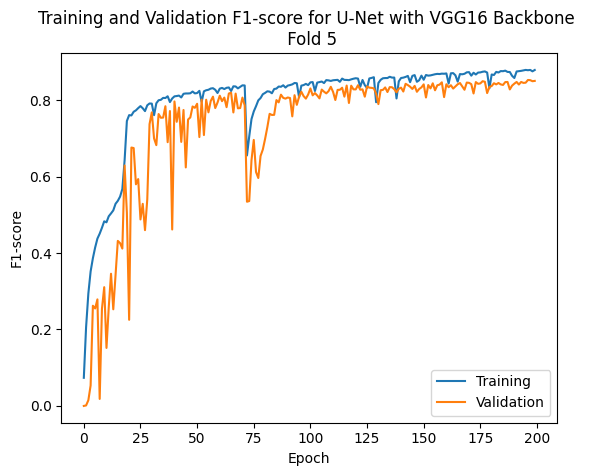

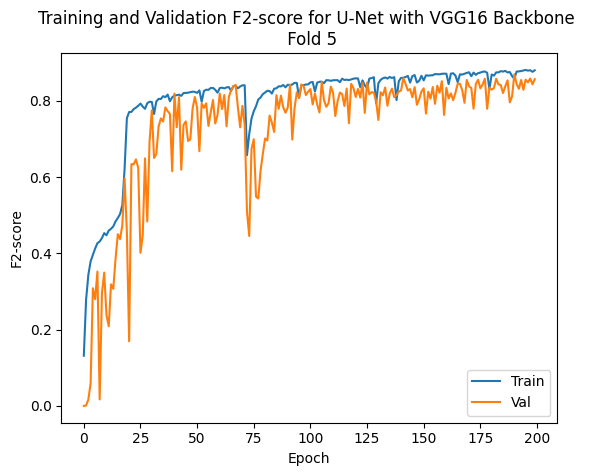

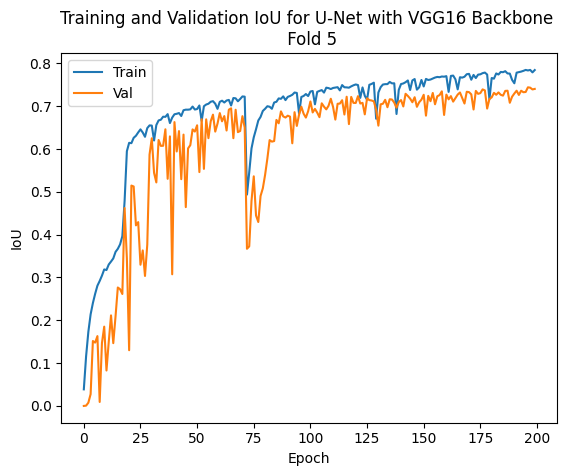

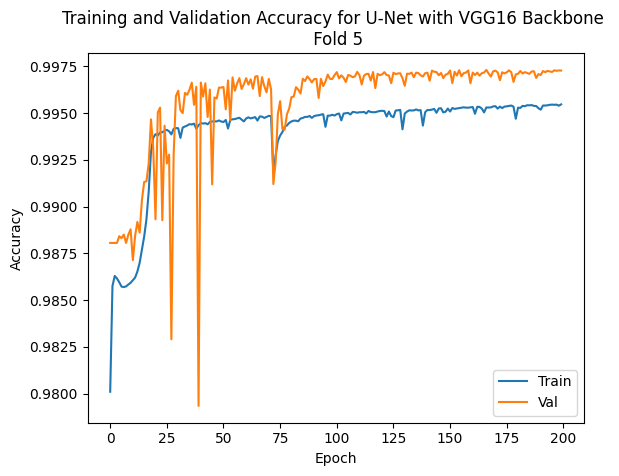

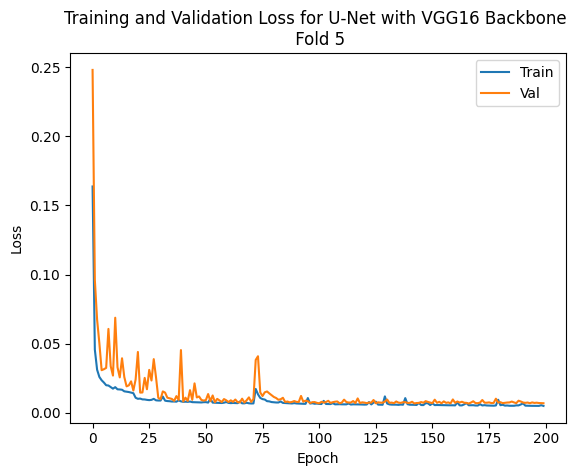

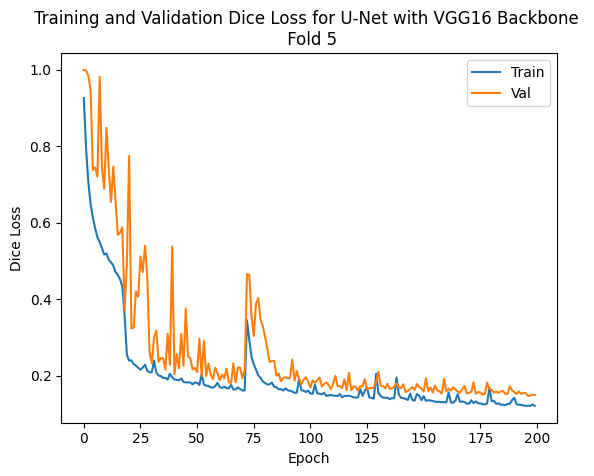

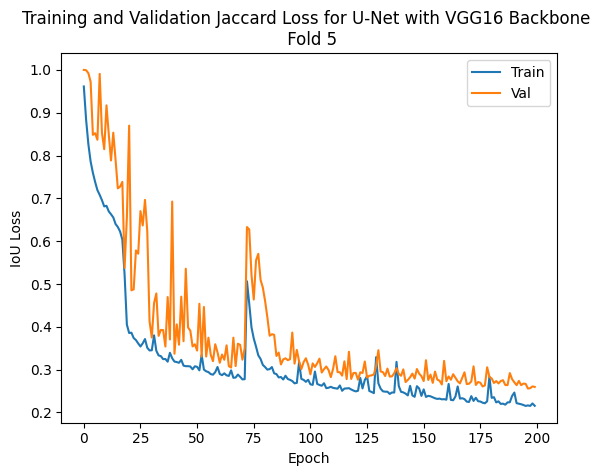

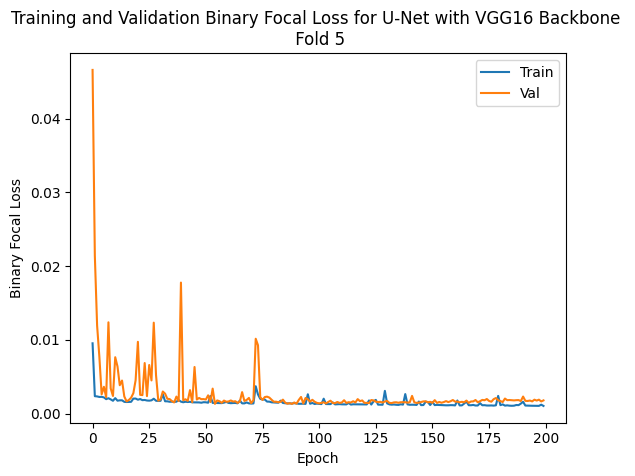

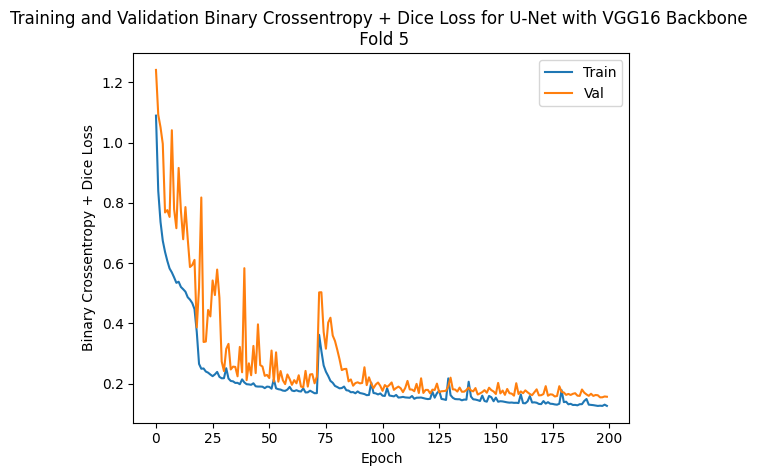

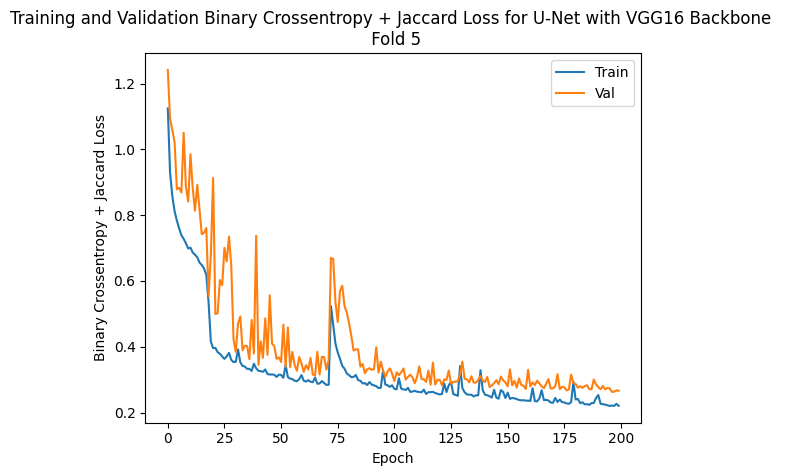

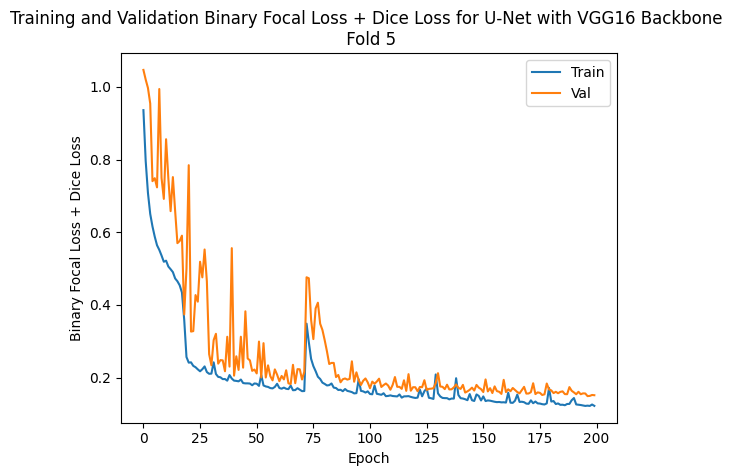

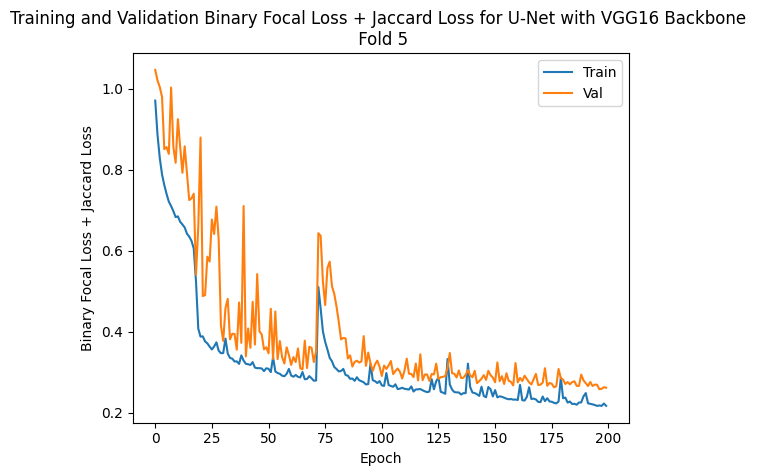

In [20]:
for i in range(4, 5):
    
    FOLDNO=1
    FOLDNO=FOLDNO+i
    
    print(FOLDNO)
    
    if FOLDNO==1:
        train_coronacases_img_fold1=train_folds[0]
        #radiopaedia_pat_fold1_train=radiopaedia_pat_unique.drop([6,8])
        valid_coronacases_img_fold1=valid_folds[0]
        #radiopaedia_pat_fold1_val=radiopaedia_pat_unique.drop([0,1,2,3,4,5,7,9])
    elif FOLDNO==2:
        train_coronacases_img_fold1=train_folds[1]
        #radiopaedia_pat_fold1_train=radiopaedia_pat_unique.drop([2,9])
        valid_coronacases_img_fold1=valid_folds[1]
        #radiopaedia_pat_fold1_val=radiopaedia_pat_unique.drop([0,1,3,4,5,6,7,8])
    elif FOLDNO==3:
        train_coronacases_img_fold1=train_folds[2]
        #radiopaedia_pat_fold1_train=radiopaedia_pat_unique.drop([0,5])
        valid_coronacases_img_fold1=valid_folds[2]
        #radiopaedia_pat_fold1_val=radiopaedia_pat_unique.drop([1,2,3,4,6,7,8,9])
    elif FOLDNO==4:
        train_coronacases_img_fold1=train_folds[3]
        #radiopaedia_pat_fold1_train=radiopaedia_pat_unique.drop([3,7])
        valid_coronacases_img_fold1=valid_folds[3]
        #radiopaedia_pat_fold1_val=radiopaedia_pat_unique.drop([0,1,2,4,5,6,8,9])
    elif FOLDNO==5:
        train_coronacases_img_fold1=train_folds[4]
        #radiopaedia_pat_fold1_train=radiopaedia_pat_unique.drop([1,4])
        valid_coronacases_img_fold1=valid_folds[4]
        #radiopaedia_pat_fold1_val=radiopaedia_pat_unique.drop([0,2,3,5,6,7,8,9])
        
    #pat_fold1_train=coronacases_pat_fold1_train
    #pat_fold1_val=coronacases_pat_fold1_val
    #pat_fold1_test=radiopaedia_pat_unique
    
    #train_coronacases_img_fold1=final_coronacases_df[final_coronacases_df['patient_id'].isin(coronacases_pat_fold1_train[0])]
    #valid_coronacases_img_fold1=final_coronacases_df[final_coronacases_df['patient_id'].isin(coronacases_pat_fold1_val[0])]

    train_img_fold1=pd.DataFrame({'image_name': train_coronacases_img_fold1})
    valid_img_fold1=pd.DataFrame({'image_name': valid_coronacases_img_fold1})
    
    train_img_fold1['image_path'] = image_path + train_img_fold1['image_name']
    train_img_fold1['mask_path'] = mask_path + train_img_fold1['image_name']
    
    valid_img_fold1['image_path'] = image_path + valid_img_fold1['image_name']
    valid_img_fold1['mask_path'] = mask_path + valid_img_fold1['image_name'] 
    
    #test_img=final_radiopaedia_df[final_radiopaedia_df['patient_id'].isin(pat_fold1_test[0])]
    
    valX, valY = np.empty((2, len(valid_img_fold1['image_name']), IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.float32)

    for i, image in enumerate(valid_img_fold1['image_name']):
        # changing value type uint to int, float is changed to calculate
        img = cv2.imread(image_path + image, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE))
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
        valX[i] = np.expand_dims(img, axis = 2)
    
    for i, image in enumerate(valid_img_fold1['image_name']):
        img = cv2.imread(mask_path + image, cv2.IMREAD_UNCHANGED).astype('float32')
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE))
        valY[i] = np.expand_dims(img, axis = 2)
    valY /= 255.
    
    sm.set_framework('tf.keras')
    sm.framework()

    base_model = sm.Unet(backbone_name=BACKBONE,
                  encoder_weights='imagenet',
                  classes=CLASSES, 
                  activation=ACTIVATION)

    seg_model = Sequential([Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS)),
                        Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                        base_model])
    
    seg_model.summary()
    
    seg_model.compile(optimizer = Adam(learning_rate = LEARNING_RATE),
                          loss = CROSSENTROPY, metrics = [f1_score, f2_score, iou_score, precision, recall, 'acc', jaccard_loss, dice_loss, binary_focal_loss, bce_dice_loss, bce_jaccard_loss, binary_focal_dice_loss, binary_focal_jaccard_loss], run_eagerly= True)
    
    os.mkdir('/kaggle/working/'+MODEL_NAME)
    os.mkdir('/kaggle/working/'+MODEL_NAME+'/metrics')
    os.mkdir('/kaggle/working/'+MODEL_NAME+'/models')
    os.mkdir('/kaggle/working/'+MODEL_NAME+'/f1score_figure')
    os.mkdir('/kaggle/working/'+MODEL_NAME+'/f2score_figure')
    os.mkdir('/kaggle/working/'+MODEL_NAME+'/iou_figure')
    os.mkdir('/kaggle/working/'+MODEL_NAME+'/dice_loss_figure')
    os.mkdir('/kaggle/working/'+MODEL_NAME+'/jaccard_loss_figure')
    os.mkdir('/kaggle/working/'+MODEL_NAME+'/binary_focal_loss_figure')
    os.mkdir('/kaggle/working/'+MODEL_NAME+'/bce_dice_loss_figure')
    os.mkdir('/kaggle/working/'+MODEL_NAME+'/bce_jaccard_loss_figure')
    os.mkdir('/kaggle/working/'+MODEL_NAME+'/binary_focal_dice_loss_figure')
    os.mkdir('/kaggle/working/'+MODEL_NAME+'/binary_focal_jaccard_loss_figure')
    os.mkdir('/kaggle/working/'+MODEL_NAME+'/acc_figure')
    os.mkdir('/kaggle/working/'+MODEL_NAME+'/loss_figure')

    #  train generator

    timage_generator = timagegen.flow_from_dataframe(dataframe=train_img_fold1,
                                            x_col="image_path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            shuffle=True,
                                            target_size=(IMG_SIZE,IMG_SIZE),
                                            color_mode='grayscale')

    tmask_generator = tmaskgen.flow_from_dataframe(dataframe=train_img_fold1,
                                            x_col="mask_path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            shuffle=True,
                                            target_size=(IMG_SIZE,IMG_SIZE),
                                            color_mode='grayscale')
    
    #train generator
    vimage_generator = vimagegen.flow_from_dataframe(dataframe=valid_img_fold1,
                                             x_col = "image_path",
                                             batch_size = BATCH_SIZE,
                                             seed=42,
                                             class_mode=None,
                                             shuffle=False,
                                             target_size = (IMG_SIZE,IMG_SIZE),
                                             color_mode='grayscale')
    # validation data generator
    vmask_generator = vmaskgen.flow_from_dataframe(dataframe=valid_img_fold1,
                                             x_col = "mask_path",
                                             batch_size = BATCH_SIZE,
                                             seed=42,
                                             class_mode=None,
                                             shuffle=False,
                                             target_size = (IMG_SIZE,IMG_SIZE),
                                             color_mode='grayscale')
    
    train_gen = data_iterator(timage_generator, tmask_generator)
    val_gen = data_iterator(vimage_generator,vmask_generator)
    
    STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
    STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE
    
    checkpoint=ModelCheckpoint('/kaggle/working/'+MODEL_NAME+'/models/model_'+str(FOLDNO)+'.h5',monitor='val_f1-score',mode='max',save_best_only=SAVE_BEST_ONLY,verbose=1)
    history = seg_model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=checkpoint,
                    validation_data=val_gen,
                    validation_steps=STEP_SIZE_VALID)

    history_fold=history.history
    
    print(history.history['f1-score'][-1])
    print(history.history['f2-score'][-1])
    print(history.history['iou_score'][-1])
    print(history.history['precision'][-1])
    print(history.history['recall'][-1])
    print(history.history['acc'][-1])
    print(history.history['loss'][-1])
    print(history.history['binary_focal_loss'][-1])
    print(history.history['dice_loss'][-1])
    print(history.history['jaccard_loss'][-1])
    print(history.history['binary_crossentropy_plus_dice_loss'][-1])
    print(history.history['binary_crossentropy_plus_jaccard_loss'][-1])
    print(history.history['binary_focal_loss_plus_dice_loss'][-1])
    print(history.history['binary_focal_loss_plus_jaccard_loss'][-1])
    
    print(history.history['val_f1-score'][-1])
    print(history.history['val_f2-score'][-1])
    print(history.history['val_iou_score'][-1])
    print(history.history['val_precision'][-1])
    print(history.history['val_recall'][-1])
    print(history.history['val_acc'][-1])
    print(history.history['val_loss'][-1])
    print(history.history['val_binary_focal_loss'][-1])
    print(history.history['val_dice_loss'][-1])
    print(history.history['val_jaccard_loss'][-1])
    print(history.history['val_binary_crossentropy_plus_dice_loss'][-1])
    print(history.history['val_binary_crossentropy_plus_jaccard_loss'][-1])
    print(history.history['val_binary_focal_loss_plus_dice_loss'][-1])
    print(history.history['val_binary_focal_loss_plus_jaccard_loss'][-1])
    
    train_f1=str(history.history['f1-score'][-1])
    train_f2=str(history.history['f2-score'][-1])
    train_iou=str(history.history['iou_score'][-1])
    train_precision=str(history.history['precision'][-1])
    train_recall=str(history.history['recall'][-1])
    train_acc=str(history.history['acc'][-1])
    train_loss=str(history.history['loss'][-1])
    train_dice_loss=str(history.history['dice_loss'][-1])
    train_jaccard_loss=str(history.history['jaccard_loss'][-1])
    train_binary_focal_loss=str(history.history['binary_focal_loss'][-1])
    train_bce_dice_loss=str(history.history['binary_crossentropy_plus_dice_loss'][-1])
    train_bce_jaccard_loss=str(history.history['binary_crossentropy_plus_jaccard_loss'][-1])
    train_focal_dice_loss=str(history.history['binary_focal_loss_plus_dice_loss'][-1])
    train_focal_jaccard_loss=str(history.history['binary_focal_loss_plus_jaccard_loss'][-1])
    
    val_f1=str(history.history['val_f1-score'][-1])
    val_f2=str(history.history['val_f2-score'][-1])
    val_iou=str(history.history['val_iou_score'][-1])
    val_precision=str(history.history['val_precision'][-1])
    val_recall=str(history.history['val_recall'][-1])
    val_acc=str(history.history['val_acc'][-1])
    val_loss=str(history.history['loss'][-1])
    val_dice_loss=str(history.history['val_dice_loss'][-1])
    val_jaccard_loss=str(history.history['val_jaccard_loss'][-1])
    val_binary_focal_loss=str(history.history['val_binary_focal_loss'][-1])
    val_bce_dice_loss=str(history.history['val_binary_crossentropy_plus_dice_loss'][-1])
    val_bce_jaccard_loss=str(history.history['val_binary_crossentropy_plus_jaccard_loss'][-1])
    val_focal_dice_loss=str(history.history['val_binary_focal_loss_plus_dice_loss'][-1])
    val_focal_jaccard_loss=str(history.history['val_binary_focal_loss_plus_jaccard_loss'][-1])
    
    data1=[]
    data1.append([FOLDNO,train_acc,train_loss,train_precision,train_recall,train_f1,train_f2,train_iou,train_dice_loss,train_jaccard_loss,train_binary_focal_loss,train_bce_dice_loss,train_bce_jaccard_loss,train_focal_dice_loss,train_focal_jaccard_loss])

    training_metrics = pd.DataFrame(data1, columns = ['Fold','Training Accuracy', 'Training Loss','Training Precision', 'Training Recall', 'Training F1-Score', 'Training F2-Score', 'Training IOU', 'Training Dice Loss', 'Training Jaccard Loss', 'Training Binary Focal Loss', 'Training BCE Dice Loss', 'Training BCE Jaccard Loss', 'Training Focal Dice Loss', 'Training Focal Jaccard Loss'])
    
    data1_2=[]
    data1_2.append([FOLDNO,val_acc,val_loss,val_precision,val_recall,val_f1,val_f2,val_iou,val_dice_loss,val_jaccard_loss,val_binary_focal_loss,val_bce_dice_loss,val_bce_jaccard_loss,val_focal_dice_loss,val_focal_jaccard_loss])
    
    validation_metrics = pd.DataFrame(data1_2, columns = ['Fold','Validation Accuracy', 'Validation Loss','Validation Precision', 'Validation Recall', 'Validation F1-Score', 'Validation F2-Score', 'Validation IOU', 'Validation Dice Loss', 'Validation Jaccard Loss', 'Validation Binary Focal Loss', 'Validation BCE Dice Loss', 'Validation BCE Jaccard Loss', 'Validation Focal Dice Loss', 'Validation Focal Jaccard Loss'])
    
    training_metrics.to_excel("/kaggle/working/"+MODEL_NAME+"/metrics/training_metrics.xlsx",
             sheet_name='Sheet1')  
    
    validation_metrics.to_excel("/kaggle/working/"+MODEL_NAME+"/metrics/validation_metrics.xlsx",
             sheet_name='Sheet1')  
    
    data2=[]
    data2.append([MODEL_NAME,N_SPLITS,IMG_SIZE,CHANNELS,LEARNING_RATE,BATCH_SIZE,CLASSES,EPOCHS,ACTIVATION,ACTF,CROSSENTROPY,OPTIMIZER,BACKBONE,RESCALE,AUGMENTATION,ROTATION_RANGE,HEIGHT_SHIFT_RANGE,WIDTH_SHIFT_RANGE,HORIZONTAL_FLIP,NORMALIZED,SPLIT,SEGMENTED,FOLDNO])

    hyperparameters = pd.DataFrame(data2, columns = ['Model Name', 'Number of Splits', 'Image Size', 'Channels','Initial LR','Batch Size','Classes','Epochs','Activation','Actf','Crossentropy','Optimizer','Backbone','Rescale','Implements Augmentation','Rotation Range','Height Shift Range','Width Shift Range','Horizontal Flip','Normalized','Split','Segmented','Number of Folds'])
    
    hyperparameters.to_excel("/kaggle/working/"+MODEL_NAME+"/metrics/hyperparameters.xlsx",
             sheet_name='Sheet1') 
    
    history_df_fold = pd.DataFrame(history_fold)
    
    history_df_fold.to_excel("/kaggle/working/"+MODEL_NAME+"/metrics/history_df_fold.xlsx",
             sheet_name='Sheet1')
    
    plot_f1score(history, MODEL_NAME, FOLDNO ,"Training and Validation F1-score for "+MODEL_NAME+" \n Fold "+str(FOLDNO))
    
    plot_f2score(history, MODEL_NAME, FOLDNO ,"Training and Validation F2-score for "+MODEL_NAME+" \n Fold "+str(FOLDNO))
    
    plot_iou(history, MODEL_NAME, FOLDNO ,"Training and Validation IoU for "+MODEL_NAME+" \n Fold "+str(FOLDNO))
    
    plot_acc(history, MODEL_NAME, FOLDNO ,"Training and Validation Accuracy for "+MODEL_NAME+" \n Fold "+str(FOLDNO))
    
    plot_loss(history, MODEL_NAME, FOLDNO ,"Training and Validation Loss for "+MODEL_NAME+" \n Fold "+str(FOLDNO))
    
    plot_dice_loss(history, MODEL_NAME, FOLDNO ,"Training and Validation Dice Loss for "+MODEL_NAME+" \n Fold "+str(FOLDNO))
    
    plot_jaccard_loss(history, MODEL_NAME, FOLDNO ,"Training and Validation Jaccard Loss for "+MODEL_NAME+" \n Fold "+str(FOLDNO))
    
    plot_binary_focal_loss(history, MODEL_NAME, FOLDNO ,"Training and Validation Binary Focal Loss for "+MODEL_NAME+" \n Fold "+str(FOLDNO))
    
    plot_bce_dice_loss(history, MODEL_NAME, FOLDNO ,"Training and Validation Binary Crossentropy + Dice Loss for "+MODEL_NAME+" \n Fold "+str(FOLDNO))
    
    plot_bce_jaccard_loss(history, MODEL_NAME, FOLDNO ,"Training and Validation Binary Crossentropy + Jaccard Loss for "+MODEL_NAME+" \n Fold "+str(FOLDNO))
    
    plot_binary_focal_dice_loss(history, MODEL_NAME, FOLDNO ,"Training and Validation Binary Focal Loss + Dice Loss for "+MODEL_NAME+" \n Fold "+str(FOLDNO))
    
    plot_binary_focal_jaccard_loss(history, MODEL_NAME, FOLDNO ,"Training and Validation Binary Focal Loss + Jaccard Loss for "+MODEL_NAME+" \n Fold "+str(FOLDNO))
    
    seg_model.load_weights('/kaggle/working/'+MODEL_NAME+'/models/model_'+str(FOLDNO)+'.h5')
    
    preds = seg_model.evaluate(val_gen, steps=STEP_SIZE_VALID, verbose=1)
    
    preds = seg_model.predict(valX)
    prediction = preds > 0.5
    
    res_f1score = sm.metrics.f1_score(valY, preds).numpy()
    res_f2score = sm.metrics.f2_score(valY, preds).numpy()
    res_iouscore = sm.metrics.iou_score(valY, preds).numpy()
    res_precision = sm.metrics.precision(valY, preds).numpy()
    res_recall = sm.metrics.recall(valY, preds).numpy()
    res_dice_loss = sm.losses.dice_loss(valY, preds).numpy()
    res_jaccard_loss = sm.losses.jaccard_loss(valY, preds).numpy()
    res_binary_focal_loss = sm.losses.binary_focal_loss(valY, preds).numpy()
    res_bce_dice_loss = sm.losses.bce_dice_loss(valY, preds).numpy()
    res_bce_jaccard_loss = sm.losses.bce_jaccard_loss(valY, preds).numpy()
    res_binary_focal_dice_loss = sm.losses.binary_focal_dice_loss(valY, preds).numpy()
    res_binary_focal_jaccard_loss = sm.losses.binary_focal_jaccard_loss(valY, preds).numpy()
    
    print(res_f1score)
    print(res_f2score)
    print(res_iouscore)
    print(res_precision)
    print(res_recall)
    print(res_dice_loss)
    print(res_jaccard_loss)
    print(res_binary_focal_loss)
    print(res_bce_dice_loss)
    print(res_bce_jaccard_loss)
    print(res_binary_focal_dice_loss)
    print(res_binary_focal_jaccard_loss)
    
    val_data=[]
    val_data.append([res_f1score, res_f2score, res_iouscore, res_precision, res_recall, res_dice_loss, res_jaccard_loss, res_binary_focal_loss, res_bce_dice_loss, res_bce_jaccard_loss, res_binary_focal_dice_loss, res_binary_focal_jaccard_loss])
    
    validation_results = pd.DataFrame(val_data, columns = ['Val F1-Score', 'Val F2-Score', 'Val IOU-Score', 'Val Precision','Val Recall','Val Dice Loss','Val Jaccard Loss','Val Binary Focal Loss','Val BCE Dice Loss','Val BCE Jaccard Loss','Val Binary Focal Dice Loss','Val Binary Focal Jaccard Loss'])
    
    validation_results.to_excel("/kaggle/working/"+str(MODEL_NAME)+"/metrics/validation_results.xlsx",
             sheet_name='Sheet1') 
    
    preds = seg_model.evaluate(test_gen, steps=STEP_SIZE_TEST, verbose=1)
    
    preds = seg_model.predict(testX)
    prediction = preds > 0.5
    
    res_f1score = sm.metrics.f1_score(testY, preds).numpy()
    res_f2score = sm.metrics.f2_score(testY, preds).numpy()
    res_iouscore = sm.metrics.iou_score(testY, preds).numpy()
    res_precision = sm.metrics.precision(testY, preds).numpy()
    res_recall = sm.metrics.recall(testX, preds).numpy()
    res_dice_loss = sm.losses.dice_loss(testY, preds).numpy()
    res_jaccard_loss = sm.losses.jaccard_loss(testY, preds).numpy()
    res_binary_focal_loss = sm.losses.binary_focal_loss(testY, preds).numpy()
    res_bce_dice_loss = sm.losses.bce_dice_loss(testY, preds).numpy()
    res_bce_jaccard_loss = sm.losses.bce_jaccard_loss(testY, preds).numpy()
    res_binary_focal_dice_loss = sm.losses.binary_focal_dice_loss(testY, preds).numpy()
    res_binary_focal_jaccard_loss = sm.losses.binary_focal_jaccard_loss(testY, preds).numpy()
    
    print(res_f1score)
    print(res_f2score)
    print(res_iouscore)
    print(res_precision)
    print(res_recall)
    print(res_dice_loss)
    print(res_jaccard_loss)
    print(res_binary_focal_loss)
    print(res_bce_dice_loss)
    print(res_bce_jaccard_loss)
    print(res_binary_focal_dice_loss)
    print(res_binary_focal_jaccard_loss)
    
    test_data=[]
    test_data.append([res_f1score, res_f2score, res_iouscore, res_precision, res_recall, res_dice_loss, res_jaccard_loss, res_binary_focal_loss, res_bce_dice_loss, res_bce_jaccard_loss, res_binary_focal_dice_loss, res_binary_focal_jaccard_loss])
    
    test_results = pd.DataFrame(test_data, columns = ['Test F1-Score', 'Test F2-Score', 'Val IOU-Score', 'Test Precision','Test Recall','Test Dice Loss','Test Jaccard Loss','Test Binary Focal Loss','Test BCE Dice Loss','Test BCE Jaccard Loss','Test Binary Focal Dice Loss','Test Binary Focal Jaccard Loss'])
    
    test_results.to_excel("/kaggle/working/"+str(MODEL_NAME)+"/metrics/test_results.xlsx",
             sheet_name='Sheet1')
    
    shutil.make_archive(str(MODEL_NAME)+"_"+str(ROTATION_RANGE)+"_fold_"+str(FOLDNO)+"_"+str(NORMALIZED)+"_"+str(SPLIT)+"_"+str(SEGMENTED), 'zip', "/kaggle/working/"+str(MODEL_NAME))
    
    #!rm -r numpy_dataset    
    shutil.rmtree('/kaggle/working/'+str(MODEL_NAME))
    

In [21]:
train_img_fold1

,image_name,image_path,mask_path
0,coronacases_001_100.tif,/kaggle/input/zenodo-only-infections-notsegmen...,/kaggle/input/zenodo-only-infections-notsegmen...
2,coronacases_001_102.tif,/kaggle/input/zenodo-only-infections-notsegmen...,/kaggle/input/zenodo-only-infections-notsegmen...
3,coronacases_001_103.tif,/kaggle/input/zenodo-only-infections-notsegmen...,/kaggle/input/zenodo-only-infections-notsegmen...
4,coronacases_001_104.tif,/kaggle/input/zenodo-only-infections-notsegmen...,/kaggle/input/zenodo-only-infections-notsegmen...
5,coronacases_001_105.tif,/kaggle/input/zenodo-only-infections-notsegmen...,/kaggle/input/zenodo-only-infections-notsegmen...
...,...,...,...
1346,coronacases_010_95.tif,/kaggle/input/zenodo-only-infections-notsegmen...,/kaggle/input/zenodo-only-infections-notsegmen...
1347,coronacases_010_96.tif,/kaggle/input/zenodo-only-infections-notsegmen...,/kaggle/input/zenodo-only-infections-notsegmen...
1348,coronacases_010_97.tif,/kaggle/input/zenodo-only-infections-notsegmen...,/kaggle/input/zenodo-only-infections-notsegmen...
1349,coronacases_010_98.tif,/kaggle/input/zenodo-only-infections-notsegmen...,/kaggle/input/zenodo-only-infections-notsegmen...


In [23]:
print('AAAA')

AAAA
